<h2>About this Project</h2>
<p>In this project, you will build an email spam filter by implementing ridge regression loss and gradient descent. You will also have an opportunity to adjust the feature extraction and model training to improve your spam filter and test it against a hiddent dataset.</p>

<h3>Evaluation</h3>

<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run a series of tests on your code. You will receive instant feedback from the autograder that will identify issues with and errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells, not just those you’ve edited, to ensure the code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p><strong>This exercise must be successfully completed in order to receive credit for this course.</strong><p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder/Instructor Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder/instructor review. Follow these steps:</p>

<ol>
<li>Save your notebook. Though the system should automatically save your progress, you should ensure the latest version of your work is saved before submitting. </li>
  <li>In the blue menu bar along the top of the code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li>Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li>The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
</ol>


<h2>Before You Code</h2>
    
<h3>Computing Derivatives</h3>

<p>  In this project you will need the gradient for several loss functions with respect to the weight vector $\mathbf{w}$:
</p>

<ol>
    <li> Ridge Regression: ${\cal L}(\mathbf{w})=\frac{1}{n}\sum_{i=1}^n (\mathbf{w}^\top \mathbf{x}_i-y_i)^2+\lambda \|\mathbf{w}\|_2^2$ </li>
    <li> L2-regularized Logistic Regression (assumes $y_i\in\{+1,-1\}$): ${\cal L}(\mathbf{w})=\frac{1}{n} \sum_{i=1}^n \log(1+\exp{(-y_i \mathbf{w}^\top \mathbf{x}_i)}) +\lambda \|\mathbf{w}\|_2^2$ 
</ol>  

<p> Note:    $\|\mathbf{w}\|_2^2=\mathbf{w}^\top \mathbf{w}$ and  $\lambda$ are non-negative constants. You have either seen or derived the gradients of these two functions before. You can either refer back to the previous sections or derive the gradients again!

<h3>Python Initialization:</h3> 

Please run the following code to initialize your Python kernel. You should be running a version of Python 3.x. </p>

In [4]:
import numpy as np
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import sys
from scipy.io import loadmat
import time
import os

%matplotlib inline

<h2>Building an Email Spam Filter</h2>
<p>You will now implement ridge loss and gradient descent. The following project parts will ask you to finish these functions in a pre-defined order.<p>

<h2>Load the Email Data</h2>
<p>The function below loads in pre-processed email data, where emails are represented as one-hot vectors.</p>

In [6]:
# tokenize the email and hashes the symbols into a vector
def extract_features_naive(path, B):
    with open(path, 'r') as email_file:
        # initialize all-zeros feature vector
        v = np.zeros(B)
        email = email_file.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            v[hash(token) % B] = 1
    return v

def load_spam_data(extract_features, B=512, path="data_train/"):
    '''
    INPUT:
    extractfeatures : function to extract features
    B               : dimensionality of feature space
    path            : the path of folder to be processed
    
    OUTPUT:
    X, Y
    '''
    
    with open(os.path.join(path, 'index'), 'r') as f:
        all_emails = [x for x in f.read().split('\n') if ' ' in x]
    
    xs = np.zeros((len(all_emails), B))
    ys = np.zeros(len(all_emails))
    for i, line in enumerate(all_emails):
        label, filename = line.split(' ')
        # make labels +1 for "spam" and -1 for "ham"
        ys[i] = (label == 'spam') * 2 - 1
        xs[i, :] = extract_features(os.path.join(path, filename), B)
    print('Loaded %d input emails.' % len(ys))
    return xs, ys

X,Y = load_spam_data(extract_features_naive)
X.shape

Loaded 5000 input emails.


(5000, 512)

<h2>Split Your Dataset</h2>

<p>Now that you have a dataset, it's time to split it inot training and testing. To evaluate your algorithm you should split off 20% of this data into a testing set.<p>

In [7]:
# Split data into training (xTr and yTr) and testing (xTv and yTv)
n, d = X.shape
# Allocate 80% of the data for training and 20% for testing
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = X[:cutoff,:]
yTr = Y[:cutoff]
# indices of testing samples
xTv = X[cutoff:,:]
yTv = Y[cutoff:]

<p>This should generate a training data set <code>xTr</code>, <code>yTr</code> and a validation set <code>xTv</code>, <code>yTv</code> for you. </p>

<p>It is now time to implement your classifiers. We will always use the gradient descent algorithm, but with various loss functions. 
First implement the function <code>ridge</code> which computes the ridge regression loss and gradient for a particular data set <code>xTr</code>, <code>yTr</code> and a weight vector <code>w</code>. Make sure you don't forget to incorporate your regularization constant $\lambda$. </p>

In [4]:
def ridge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape

    #raise NotImplementedError('Your code goes here!')

    # BEGIN SOLUTION
    preds = xTr @ (w)
    diff = preds - yTr
    loss = np.mean(diff ** 2) + lmbda * w.dot(w)
    grad = 2.0 * (xTr.T) @(diff) /n  + 2*lmbda * w
    # END SOLUTION
    
    return loss, grad

<p>An  alternative to  deriving the gradient analytically is to estimate it numerically. This is very slow, but it is a convenient  way to check your code for correctness.  The following function  uses numerical differentiation to evaluate the correctness of ridge.  If your code is correct, the norm difference between the two should be very small (smaller than $10^{-8}$). 
Keep in mind that this only checks if the gradient corresponds to the loss, but not if the loss is correct. The function also plots an image of the gradient values (blue) and their estimates (red). If everything is correct, these two should be right on top of each other.
</p>

The norm ratio is 3.9046185700363716e-10.


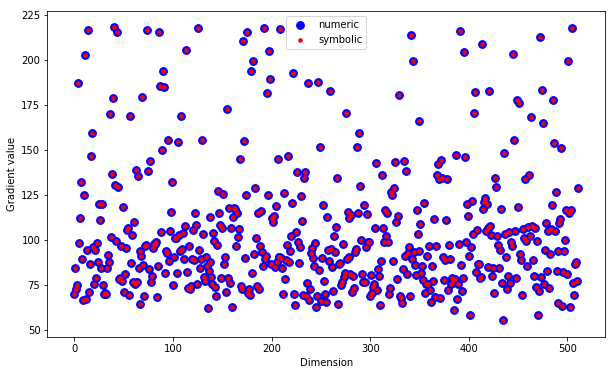

In [5]:
def numerical_gradient(fun,w,e):
    # get dimensionality
    d = len(w)
    # initialize numerical derivative
    dh = np.zeros(d)
    # go through dimensions to compute directional derivative
    for i in range(d):
        # copy the weight vector
        nw = w.copy()
        # perturb dimension i
        nw[i] += e
        # compute loss
        l1, temp = fun(nw)
        # perturb dimension i again
        nw[i] -= 2*e
        # compute loss
        l2, temp = fun(nw)
        # the gradient is the slope of the loss
        dh[i] = (l1 - l2) / (2*e)
    return dh

def check_grad(fun,w,e, plot=True):
    # evaluate symbolic gradient from fun()
    loss, dy = fun(w)
    # estimate gradient numerically from fun()
    dh = numerical_gradient(fun,w,e)
    
    ii = np.arange(len(dy))
    if plot:
        plt.figure(figsize=(10,6))
        plt.scatter(ii, dh[ii], c='b', marker='o', s=60)
        plt.scatter(ii, dy[ii], c='r', marker='.', s=50)
        plt.xlabel('Dimension')
        plt.ylabel('Gradient value')
        plt.legend(["numeric","symbolic"])
    
    # return the norm of the difference scaled by the norm of the sum
    return np.linalg.norm(dh - dy) / np.linalg.norm(dh + dy)

# set lmbda (λ) arbitrarily
lmbda = 0.1
# dimensionality of the input
_, d = xTr.shape
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
ratio = check_grad(lambda weight: ridge(weight,xTr,yTr,lmbda), w, 1e-05)
print("The norm ratio is {}.".format(ratio))

<p>Implement the function <code>grad_descent</code> which performs adaptive gradient descent. 
Make sure to include the tolerance variable to stop early if the norm of the gradient is less than the tolerance value (you can use the function <code>np.linalg.norm(x)</code>). When the norm of the gradient is tiny it means that you have arrived at a minimum.  <br>
The first parameter of <code>grad_descent</code> is a function which takes a weight vector and returns loss and gradient.
</p>                

In [6]:
def grad_descent(func,w,alpha,maxiter,delta=1e-02):
    """
    INPUT:
    func    : function to minimize
              (loss, gradient = func(w))
    w       : d dimensional initial weight vector 
    alpha   : initial gradient descent stepsize (scalar)
    maxiter : maximum amount of iterations (scalar)
    delta   : if norm(gradient)<delta, it quits (scalar)
    
    OUTPUTS:
     
    w      : d dimensional final weight vector
    losses : vector containing loss at each iteration
    """
    
    losses = np.zeros(maxiter)

    #raise NotImplementedError('Your code goes here!')

    ### BEGIN SOLUTION
    for i in range(maxiter):
        losses[i], grad = func(w)
        w -= alpha * grad
        if np.linalg.norm(grad) < delta: 
            losses = losses[:i+1]
            break
    ### END SOLUTION
    return w, losses

Final Loss: 0.738324


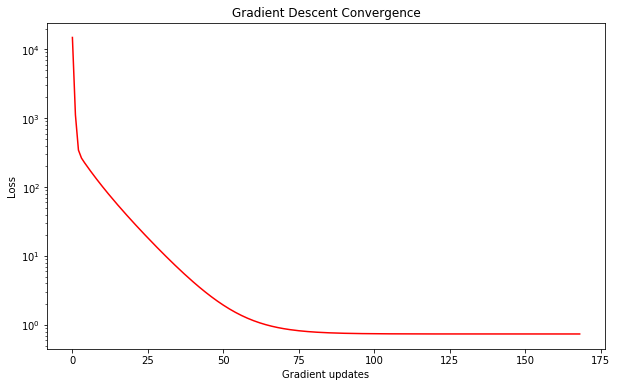

In [7]:
_, d = xTr.shape
lmbda = 5
w, losses = grad_descent(lambda weight: ridge(weight, xTr, yTr, lmbda), np.random.rand(d), 0.005, 4000)

plt.figure(figsize=(10,6))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("Gradient updates")
plt.ylabel("Loss")
plt.title("Gradient Descent Convergence")
print("Final Loss: %f" % losses[-1])

<p> Write the (almost trivial) function <code>linclassify</code> which returns the predictions for a vector <code>w</code> and a data set <code>xTv</code>. (You can take it from a previous project.)</p>

<p>After this you can check your training and validation accuracy by running the cell below.</p>

In [8]:
def linclassify(w,xTr):
    ### BEGIN SOLUTION
    return np.sign(xTr.dot(w))
    ### END SOLUTION

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 87.08%
Validation accuracy 90.40%



<p>Now implement the other loss function, <code>logistic</code>

In [8]:
def logistic(w,xTr,yTr, lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    #raise NotImplementedError('Your code goes here!')

    ### BEGIN SOLUTION
    e = np.exp((xTr@w).flatten() * - yTr)
    loss = np.sum(np.log(1+e)) / n + lmbda * w.dot(w)
    grad = np.dot(e * -yTr/(1+e), xTr) / n + 2*lmbda * w
    ### END SOLUTION
    
    return loss,grad

<p>You can use the two cells below to test how well this loss function performs.</p>

The norm ratio is 3.6168559299008324e-10


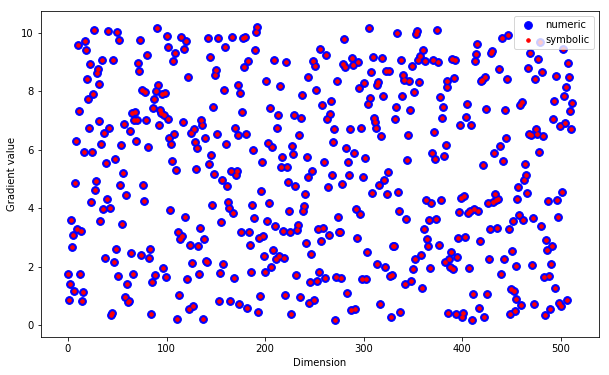

In [10]:
# Gradient sanity check
_, d = xTr.shape
w = np.random.rand(d)
ratio = check_grad(lambda weight: logistic(weight,xTr,yTr, lmbda),w,1e-05)
print("The norm ratio is {}".format(ratio))

Final Loss: 0.549331
Training accuracy 87.83%
Validation accuracy 91.20%



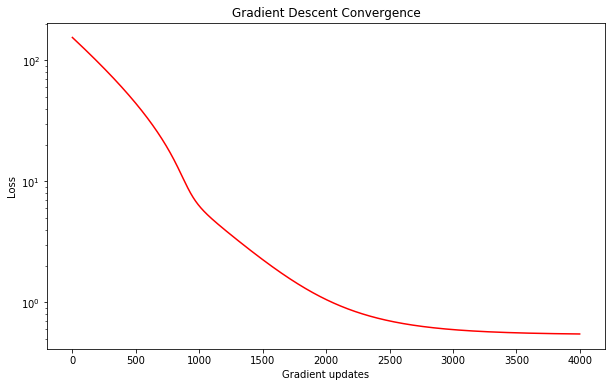

In [11]:
lmbda = 0.5
w, losses = grad_descent(lambda weight: logistic(weight, xTr, yTr, lmbda), np.random.rand(d), 0.001, 4000)

plt.figure(figsize=(10,6))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("Gradient updates")
plt.ylabel("Loss")
plt.title("Gradient Descent Convergence")
print("Final Loss: %f" % losses[-1])

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

<h2>Extension: Improve Your Spam Classifier <b>[Ungraded]</b></h2>

<p>You can improve your classifier in two ways:</p>

<ol>
<li><b>Feature Extraction</b>:
Modify the function <code>extract_features_comp()</code>.
This function takes in a file path <code>path</code> and
a feature dimension <code>B</code> and should output a feature vector of dimension <code>B</code>.
The autograder will pass in a file path pointing to a file that contains an email,
and set <code>B</code> = <code>feature_dimension</code>.
We provide a naive feature extraction as an example.
</li>
<li><b>Model Training</b>:
Modify the function <code>train_spam_filter_comp()</code>.
This function takes in training data <code>xTr</code> and training labels <code>yTr</code> and
should output a weight vector <code>w</code> for linear classification.
We provide an initial implementation using gradient descent and ridge regression.
</li>
</ol>

<p>Your model will be trained on the same training set above (loaded by <code>load_spam_data()</code>), but we will test its accuracy on a secret dataset of emails.</p>

In [12]:
feature_dimension = 512
def extract_features_comp(path, B=feature_dimension):
    '''
    INPUT:
    path : file path of email
    B    : dimensionality of feature vector
    
    OUTPUTS:
    x    : B dimensional vector
    '''
    x = np.zeros(B)
    with open(path, 'r') as email_file:
        email = email_file.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            x[hash(token) % B] = 1
    ### BEGIN SOLUTION
    ### END SOLUTION
    return x

In [13]:
def train_spam_filter_comp(xTr, yTr):
    '''
    INPUT:
    xTr : nxd dimensional matrix (each row is an input vector)
    yTr : d   dimensional vector (each entry is a label)
    
    OUTPUTS:
    w : d dimensional vector for linear classification
    '''
    n, d = xTr.shape
    lmbda = 5
    
    w, losses = grad_descent(lambda weight: ridge(weight, xTr, yTr, lmbda), np.random.rand(d), 0.001, 1000)
    ### BEGIN SOLUTION
    ### END SOLUTION
    return w

In [14]:
### BEGIN HIDDEN TESTS
### Instructor's solution. Do Not Modify
def ridge_grader(w,xTr,yTr,lmbda):
    n, d = xTr.shape
    preds = xTr @ (w)
    diff = preds - yTr
    loss = np.mean(diff ** 2) + lmbda * w.dot(w)
    grad = 2.0 * (xTr.T) @(diff) /n  + 2*lmbda * w
    
    return loss, grad

def grad_descent_grader(func,w,alpha,maxiter,delta=1e-02):
    losses = np.zeros(maxiter)
    for i in range(maxiter):
        losses[i], grad = func(w)
        w -= alpha * grad
        if np.linalg.norm(grad) < delta: 
            losses = losses[:i+1]
            break
    return w, losses

def logistic_grader(w,xTr,yTr, lmbda):
    n, d = xTr.shape
    
    e = np.exp((xTr@w).flatten() * - yTr)
    loss = np.sum(np.log(1+e)) / n + lmbda * w.dot(w)
    grad = np.dot(e * -yTr/(1+e), xTr) / n + 2*lmbda * w
    
    return loss,grad

def linclassify_grader(w,xTr):
    return np.sign(xTr.dot(w))

def analyze_grader(kind,truth,preds):
    truth = truth.flatten()
    preds = preds.flatten()
    if kind == 'abs':
        # compute the absolute difference between truth and predictions
        output = np.sum(np.abs(truth - preds)) / float(len(truth))
    elif kind == 'acc':
        if len(truth) == 0 and len(preds) == 0:
            output = 0
        else:
            output = np.sum(truth == preds) / float(len(truth))
    return output

N = 50
D = 5
X = np.vstack((np.random.randn(50, 5), np.random.randn(50, 5) + 2))
Y = np.hstack((np.ones(50), -np.ones(50)))
XUnit = np.array([[-1,1],[-1,0],[0,-1],[-1,2],[1,-2],[1,-1],[1,0],[0,1],[1,-2],[-1,2]])
YUnit = np.hstack((np.ones(5), -np.ones(5)))
### END HIDDEN TESTS

In [15]:
### BEGIN HIDDEN TESTS
# naive unit testing using simply w, x and y data
def ridge_test0():
    w = np.ones(2)
    [lss1,grd1] = ridge(w, XUnit, YUnit, 0.05)
    [lss2,grd2] = ridge_grader(w, XUnit, YUnit, 0.05)
    return (np.linalg.norm(lss1 - lss2) < 1e-5), (np.linalg.norm(grd1 - grd2) < 1e-5)

# Check whether gradient is consistent with loss
def ridge_test1():
    w = np.random.rand(D)
    ratio = check_grad(lambda weight: ridge(weight,X,Y,0.3),w,1e-05, False)
    return (ratio < 1e-8)

# Check whether loss is correct
def ridge_test2():
    w = np.random.rand(D)
    [lss1, grd1] = ridge(w, X, Y, 0.3)
    [lss2, grd2] = ridge_grader(w, X, Y, 0.3)
    return (np.linalg.norm(lss1 - lss2) < 1e-5)

# Check whether gradient is correct
def ridge_test3():
    w = np.random.rand(D)
    [lss1, grd1] = ridge(w, X, Y, 0.3)
    [lss2, grd2] = ridge_grader(w, X, Y, 0.3)
    return (np.linalg.norm(grd1 - grd2) < 1e-5)


ridge_unit_pass_lss, ridge_unit_pass_grd = ridge_test0()
assert ridge_unit_pass_lss, "Ridge Unit Test - loss seems incorrect for simple unit test data"
assert ridge_unit_pass_grd, "Ridge Unit Test - gradient seems incorrect for simple unit test data"
assert ridge_test1(), "Ridge: Analytical and numerical gradients don't match"
assert ridge_test2(), "Ridge: Loss seems incorrect"
assert ridge_test3(), "Ridge: Gradient seems incorrect"
### END HIDDEN TESTS

In [16]:
### BEGIN HIDDEN TESTS
# naive unit testing using simply w, x and y data
def logistic_test0():
    w = np.ones(2)
    [lss1,grd1] = logistic(w, XUnit, YUnit, 0.3)
    [lss2,grd2] = logistic_grader(w, XUnit, YUnit, 0.3)
    return (np.linalg.norm(lss1 - lss2) < 1e-5), (np.linalg.norm(grd1 - grd2) < 1e-5)

# Check whether gradient is consistent with loss
def logistic_test1():
    w = np.random.rand(D)
    ratio = check_grad(lambda weight: logistic(weight,X,Y, 0.3),w,1e-05, False)
    return (ratio < 1e-8)

# Check whether loss is correct
def logistic_test2():
    w = np.random.rand(D)
    [lss1, grd1] = logistic(w, X, Y, 0.3)
    [lss2, grd2] = logistic_grader(w, X, Y, 0.3)
    return (np.linalg.norm(lss1 - lss2) < 1e-5)

# Check whether gradient is correct
def logistic_test3():
    w = np.random.rand(D)
    [lss1, grd1] = logistic(w, X, Y, 0.3)
    [lss2, grd2] = logistic_grader(w, X, Y, 0.3)
    return (np.linalg.norm(grd1 - grd2) < 1e-5)

logistic_unit_pass_lss, logistic_unit_pass_grd = logistic_test0()
assert logistic_unit_pass_lss, "Logistic Unit Test - loss seems incorrect for simple unit test data"
assert logistic_unit_pass_grd, "Logistic Unit Test - gradient seems incorrect for simple unit test data"
assert logistic_test1(), "Logistic: Analytical and numerical gradients don't match"
assert logistic_test2(), "Logistic: Loss seems incorrect"
assert logistic_test3(), "Logistic: Gradient seems incorrect"
### END HIDDEN TESTS

In [17]:
### BEGIN HIDDEN TESTS
def linclassify_test():
    w = np.random.rand(D)
    xtoy = np.random.rand(N,D)
    pred1 = linclassify(w, xtoy)
    pred2 = linclassify_grader(w, xtoy)
    return (np.linalg.norm(pred1 - pred2) < 1e-10)

assert linclassify_test(), "Linclassify Test - linear classification seems incorrect"
### END HIDDEN TESTS

In [18]:
### BEGIN HIDDEN TESTS
# Check whether the first step of adagrad is correct
def grad_descent_test1():
    w = np.random.rand(D)
    w2 = np.copy(w)
    eps = 1e-06
    weight1, _ = grad_descent(lambda weight: ridge(weight,X,Y,0.3),w,0.001,1,eps)
    weight2, _ = grad_descent_grader(lambda weight: ridge_grader(weight,X,Y,0.3),w2,0.001,1,eps)
    return (np.linalg.norm(weight1 - weight2) < 1e-5)

# Check the convergence of adagrad
def grad_descent_test2():
    w = np.random.rand(D)
    w2 = np.copy(w)
    eps = 1e-06
    weight1, _ = grad_descent(lambda weight: ridge(weight,X,Y,0.3),w,0.001,100,eps)
    weight2, _ = grad_descent_grader(lambda weight: ridge_grader(weight,X,Y,0.3),w2,0.001,100,eps)
    return (np.linalg.norm(weight1 - weight2) < 1e-5)

# Check various steps of adagrad
def grad_descent_test3():
    w = np.random.rand(D)
    w2 = np.copy(w)
    eps = 1e-06
    for i in range(25,101,25):
        weight1, _ = grad_descent(lambda weight: ridge(weight,X,Y,0.3),w,0.001,i,eps)
        weight2, _ = grad_descent(lambda weight: ridge_grader(weight,X,Y,0.3),w2,0.001,i,eps)
        if not (np.linalg.norm(weight1 - weight2) < 1e-5): return False
    return True

assert grad_descent_test1(), "Gradient Descent Test 1 - single step using ridge seems incorrect"
assert grad_descent_test2(), "Gradient Descent Test 2 - many steps using ridge seems incorrect"
assert grad_descent_test3(), "Gradient Descent Test 3 - checking various steps using ridge seems incorrect"
### END HIDDEN TESTS

In [21]:
### BEGIN HIDDEN TESTS
def competition_test():
    xTr,yTr = load_spam_data(extract_features_comp, feature_dimension, 'data_train')
    weight = train_spam_filter_comp(xTr, yTr)
    xTe,yTe = load_spam_data(extract_features_comp, feature_dimension, 'data_test')
    preds = linclassify_grader(weight, xTe)
    pos_ind = (yTe == 1)
    neg_ind = (yTe == -1)
    pos_acc = np.mean(yTe[pos_ind] == preds[pos_ind])
    neg_acc = np.mean(yTe[neg_ind] == preds[neg_ind])
    test_accuracy = 0.5*pos_acc + 0.5*neg_acc
    return analyze_grader("acc", yTr, linclassify_grader(weight, xTr)), test_accuracy

training_acc, test_acc = competition_test()
print("Your features achieved training accuracy: {:.2f}% and test accuracy: {:.2f}%".format(training_acc*100, test_acc*100))
### END HIDDEN TESTS

Your features achieved training accuracy: 84.18% and test accuracy: 65.98%
